# Association Rules
- Transaction Definition
- Observation & Discretization
- Assocation Rules
- Explanation



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
import time
import statistics
from sklearn.cluster import KMeans
from pylab import rcParams

%matplotlib inline
rcParams['figure.figsize'] = 40, 35
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 25

# Dataset cleaner
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    # return df[indices_to_keep].astype(np.float64)
    return df[indices_to_keep]

# Data 3 - Power
- 從 2016-09-27 到 2017-09-01 的電力資料
- 北中南東各有兩個 columns ， 分別代表供給量及使用量 (Supply & Usage)
- 約每小時一筆資料

In [2]:
power = pd.read_csv("power.csv")
power.head()

,Date,Time,NorthSupply,NorthUsage,CenterSupply,CenterUsage,SouthSupply,SouthUsage,EastSupply,EastUsage
0,2016-09-27,12:10,648.4,841.3,733.0,564.4,839.6,799.9,14.0,29.3
1,2016-09-27,13:10,601.3,826.4,725.4,535.9,827.3,777.9,14.0,27.6
2,2016-09-27,14:00,500.9,789.5,759.0,506.7,821.5,771.3,13.9,27.9
3,2016-09-27,15:10,516.1,773.6,717.1,450.8,744.2,737.3,13.9,29.5
4,2016-09-27,16:00,530.2,778.0,691.6,432.2,746.0,735.3,8.7,31.0


In [3]:
power.describe()

,NorthSupply,NorthUsage,CenterSupply,CenterUsage,SouthSupply,SouthUsage,EastSupply,EastUsage
count,6060.000000,6060.000000,6060.000000,6060.000000,6060.000000,6060.000000,6060.000000,6060.000000
mean,871.774059,970.082541,760.360231,708.192706,977.277937,901.751617,8.068531,37.453020
std,169.168890,206.794644,160.876822,103.979344,138.950242,115.564858,3.983699,6.158678
min,429.200000,574.600000,329.000000,420.700000,670.200000,604.500000,0.200000,23.200000
25%,750.500000,807.450000,638.475000,629.600000,869.975000,815.875000,4.600000,32.700000
50%,863.300000,950.900000,766.700000,702.150000,965.300000,897.700000,7.500000,37.100000
75%,998.500000,1110.400000,891.200000,788.225000,1069.225000,995.125000,11.200000,41.600000
max,1237.000000,1491.700000,1166.000000,947.000000,1365.000000,1175.900000,17.600000,52.400000


## Task 1:  Net Electricity Usage Analysis of Northern, Central, Southern, and Eastern Taiwan
##### Note thta Net Electricity is dedinfed as: netE =  Supply - Usage
    - netE > 0 means the electricity supply is adequate
    - netE < 0 means the electricity supply is inadequate

### Step 1: Transaction Definition:
By adopting association rules, I try to dig out the net electricity conditions of each area so that I can analyze that which region usually help other regions with electricity aid.

In [4]:
# axis = 1: Drop selected column
q1 = power.drop(['Date'], axis=1)

# Clean up the dataset to get rid of nan, inf and -inf
q1 = clean_dataset(q1)
q1.head()

,Time,NorthSupply,NorthUsage,CenterSupply,CenterUsage,SouthSupply,SouthUsage,EastSupply,EastUsage
0,12:10,648.4,841.3,733.0,564.4,839.6,799.9,14.0,29.3
1,13:10,601.3,826.4,725.4,535.9,827.3,777.9,14.0,27.6
2,14:00,500.9,789.5,759.0,506.7,821.5,771.3,13.9,27.9
3,15:10,516.1,773.6,717.1,450.8,744.2,737.3,13.9,29.5
4,16:00,530.2,778.0,691.6,432.2,746.0,735.3,8.7,31.0


In [5]:
# netE = electricity supply - electricity usage
# netE > 0 means the electricity supply is adequate
# netE < 0 means the electricity supply is inadequate
North_netE = q1['NorthSupply'] - q1['NorthUsage']
Center_netE = q1['CenterSupply'] - q1['CenterUsage']
South_netE = q1['SouthSupply'] - q1['SouthUsage']
East_netE = q1['EastSupply'] - q1['EastUsage']
q1['North_netE'], q1['Center_netE'], q1['South_netE'], q1['East_netE'] = North_netE, Center_netE, South_netE, East_netE
q1 = q1.drop(['NorthSupply', 'NorthUsage', 'CenterSupply', 'CenterUsage', 'SouthSupply', 'SouthUsage', 'EastSupply', 'EastUsage'], axis=1)
q1.head()

,Time,North_netE,Center_netE,South_netE,East_netE
0,12:10,-192.9,168.6,39.7,-15.3
1,13:10,-225.1,189.5,49.4,-13.6
2,14:00,-288.6,252.3,50.2,-14.0
3,15:10,-257.5,266.3,6.9,-15.6
4,16:00,-247.8,259.4,10.7,-22.3


### Step 2: Observation & Discretization:

Text(0,0.5,'count')

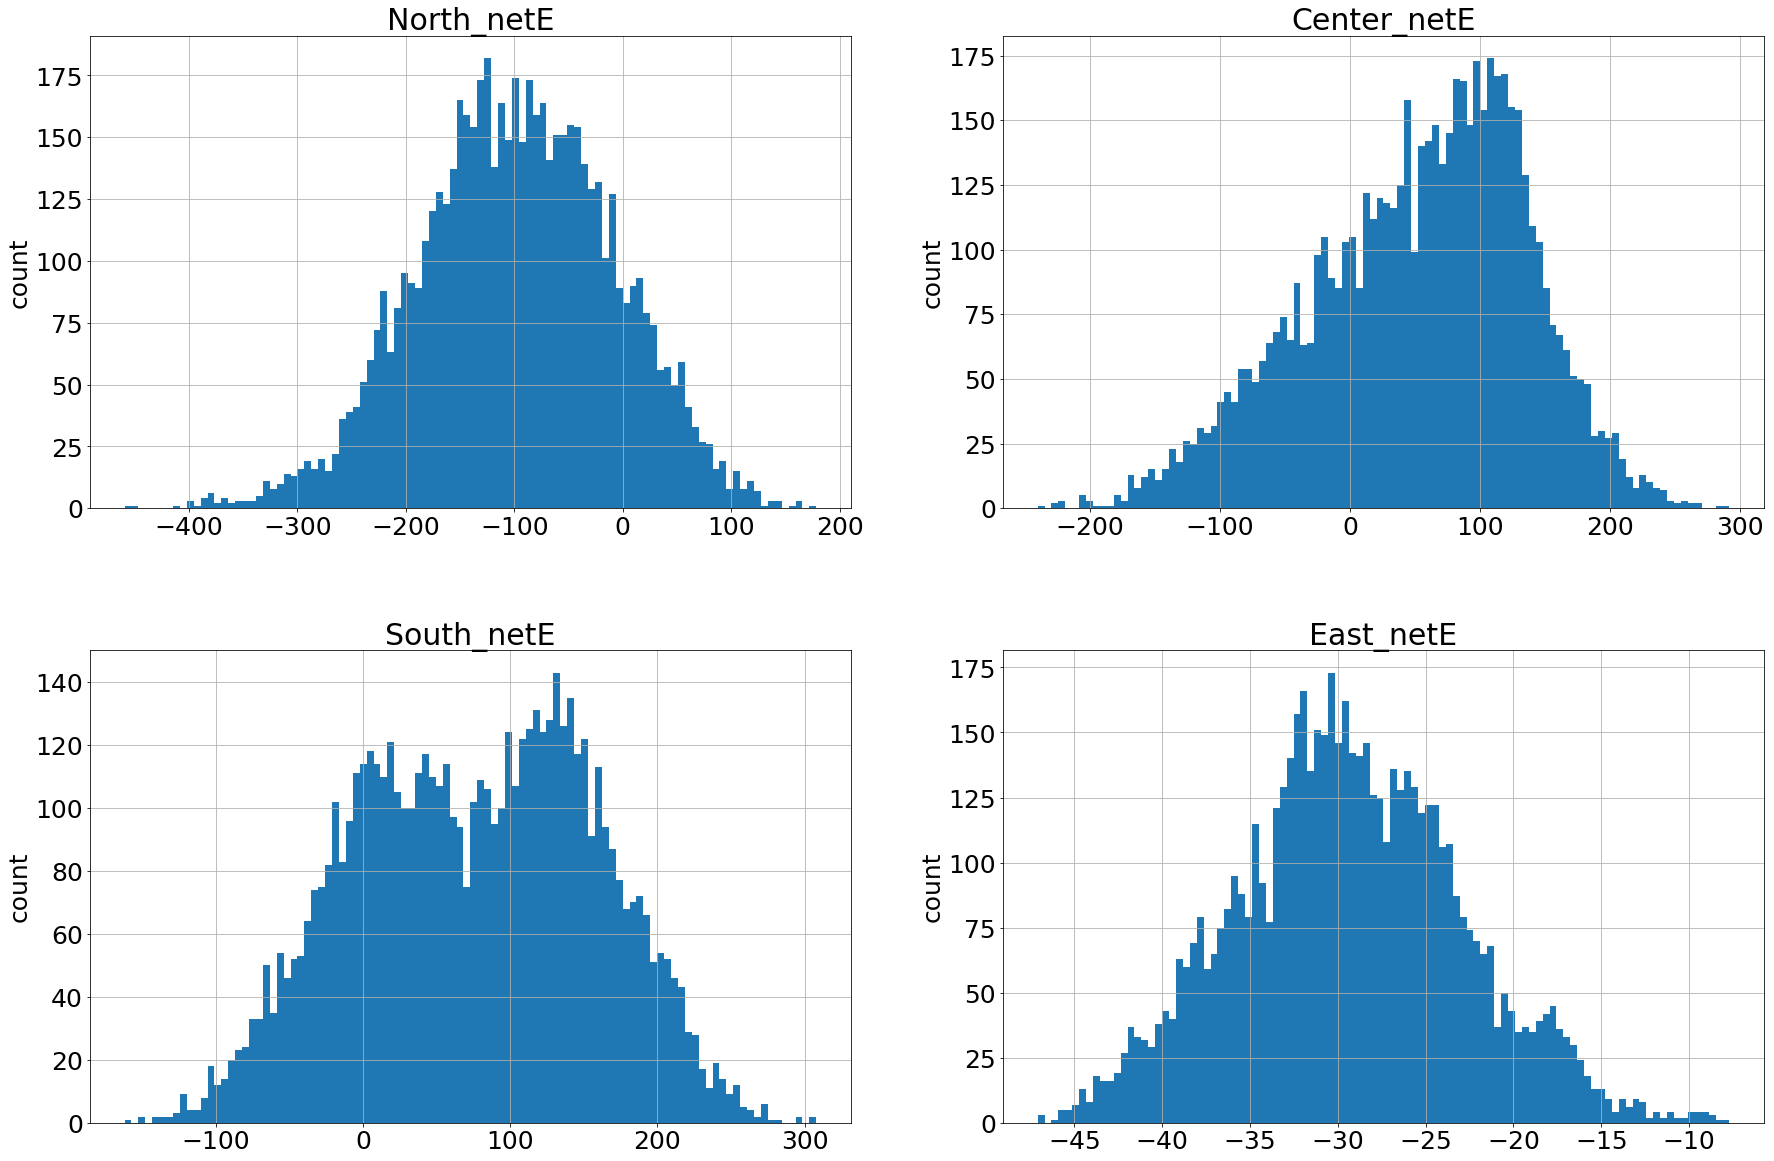

In [6]:
fig, ax = plt.subplots(figsize=(30, 20))
plt.rcParams.update({'font.size': 25})
fig.subplots_adjust(hspace=.3)

plt.subplot(2, 2, 1)
q1['North_netE'].hist(bins = 100)
plt.title('North_netE')
plt.ylabel('count')

plt.subplot(2, 2, 2)
q1['Center_netE'].hist(bins = 100)
plt.title('Center_netE')
plt.ylabel('count')

plt.subplot(2, 2, 3)
q1['South_netE'].hist(bins = 100)
plt.title('South_netE')
plt.ylabel('count')

plt.subplot(2, 2, 4)
q1['East_netE'].hist(bins = 100)
plt.title('East_netE')
plt.ylabel('count')

#### From the figures above, we observe that
- All regions are close to normal distribution.
- Using K-means clustering for all of them should be a good strategy.

#### K-means clustering:

In [7]:
N = q1[['North_netE']]
C = q1[['Center_netE']]
S = q1[['South_netE']]
E = q1[['East_netE']]
n_clusters = 5
n_kmeans = KMeans(n_clusters, random_state=0).fit(N)
c_kmeans = KMeans(n_clusters, random_state=0).fit(C)
s_kmeans = KMeans(n_clusters, random_state=0).fit(S)
e_kmeans = KMeans(n_clusters, random_state=0).fit(E)
q1['North_grp'] = n_kmeans.labels_
q1['Center_grp'] = c_kmeans.labels_
q1['South_grp'] = s_kmeans.labels_
q1['East_grp'] = e_kmeans.labels_

# Notify the upper/lower bounds of each cluster
n_max_list = list(q1.groupby('North_grp')['North_netE'].max())
n_min_list = list(q1.groupby('North_grp')['North_netE'].min())
c_max_list = list(q1.groupby('Center_grp')['Center_netE'].max())
c_min_list = list(q1.groupby('Center_grp')['Center_netE'].min())
s_max_list = list(q1.groupby('South_grp')['South_netE'].max())
s_min_list = list(q1.groupby('South_grp')['South_netE'].min())
e_max_list = list(q1.groupby('East_grp')['East_netE'].max())
e_min_list = list(q1.groupby('East_grp')['East_netE'].min())

# Modify clusters' value by specific upper/lower bounds
q1[['North_grp']] = ["[%d, %d]" % (n_min_list[i], n_max_list[i]) for i in q1['North_grp']]
q1[['Center_grp']] = ["[%d, %d]" % (c_min_list[i], c_max_list[i]) for i in q1['Center_grp']]
q1[['South_grp']] = ["[%d, %d]" % (s_min_list[i], s_max_list[i]) for i in q1['South_grp']]
q1[['East_grp']] = ["[%d, %d]" % (e_min_list[i], e_max_list[i]) for i in q1['East_grp']]

# for i in range(0, n_clusters):
#     print("North clusters: [%d, %d]" %(n_min_list[i], n_max_list[i]))
# for i in range(0, n_clusters):
#     print("Center clusters: [%d, %d]" %(c_min_list[i], c_max_list[i]))
# for i in range(0, n_clusters):
#     print("South clusters: [%d, %d]" %(s_min_list[i], s_max_list[i]))
# for i in range(0, n_clusters):
#     print("East clusters: [%d, %d]" %(e_min_list[i], e_max_list[i]))

### Step 3: Association Rules by FP-Growth:

In [8]:
# Add prefix for clarification
N_items = ['N_netE' + x for x in q1['North_grp']]
C_items = ['C_netE' + x for x in q1['Center_grp']]
S_items = ['S_netE' + x for x in q1['South_grp']]
E_items = ['E_netE' + x for x in q1['East_grp']]

dataset = []
dataset.append(N_items)
dataset.append(C_items)
dataset.append(S_items)
dataset.append(E_items)

# Transpose to generater the format of transactions
transactions = list(zip(*dataset))
transactions

[('N_netE[-215, -138]',
  'C_netE[139, 291]',
  'S_netE[39, 101]',
  'E_netE[-20, -7]'),
 ('N_netE[-459, -216]',
  'C_netE[139, 291]',
  'S_netE[39, 101]',
  'E_netE[-20, -7]'),
 ('N_netE[-459, -216]',
  'C_netE[139, 291]',
  'S_netE[39, 101]',
  'E_netE[-20, -7]'),
 ('N_netE[-459, -216]',
  'C_netE[139, 291]',
  'S_netE[-24, 39]',
  'E_netE[-20, -7]'),
 ('N_netE[-459, -216]',
  'C_netE[139, 291]',
  'S_netE[-24, 39]',
  'E_netE[-26, -20]'),
 ('N_netE[-459, -216]',
  'C_netE[139, 291]',
  'S_netE[-24, 39]',
  'E_netE[-31, -26]'),
 ('N_netE[-459, -216]',
  'C_netE[139, 291]',
  'S_netE[39, 101]',
  'E_netE[-36, -31]'),
 ('N_netE[-215, -138]',
  'C_netE[139, 291]',
  'S_netE[-24, 39]',
  'E_netE[-36, -31]'),
 ('N_netE[-215, -138]',
  'C_netE[139, 291]',
  'S_netE[-24, 39]',
  'E_netE[-36, -31]'),
 ('N_netE[-215, -138]',
  'C_netE[139, 291]',
  'S_netE[-24, 39]',
  'E_netE[-36, -31]'),
 ('N_netE[-215, -138]',
  'C_netE[139, 291]',
  'S_netE[-24, 39]',
  'E_netE[-36, -31]'),
 ('N_netE[-215

#### FP-Growth:
Orange3-fpgrowth can only deal with numeric data, so a pair of encoder/decoder is required

In [9]:
# Orange3's input must be mumeric. String is not allowed.
from orangecontrib.associate import fpgrowth as fpg
start = time.time()

itemset = set().union(*transactions)
# decoder: numeric to string
decoder = {i: k for i, k in enumerate(itemset)}
# encoder: string to numeric
encoder = {k: i for i, k in enumerate(itemset)}

# Set min. support and min. confidence
# Fine-tuning minsup and minconf can get us more insight! Try different values of them.
minsup = 50/len(transactions)
minconf = 0.7

itemsets =  dict(fpg.frequent_itemsets([[encoder[i] for i in t] for t in transactions], minsup))
rules = list(fpg.association_rules(itemsets, minconf))

print("Fpgrowth took", time.time() - start, "seconds.")
# Print # of rules
print(len(rules), "Results")

Fpgrowth took 0.07754063606262207 seconds.
75 Results


In [10]:
for rule in rules:
    a = [decoder[i] for i in rule[0]]
    b = [decoder[i] for i in rule[1]]
    s, c = rule[2], rule[3]
    print(a, ' -> ', b, c)
# c = confidence
# a -> b is the rule

['E_netE[-31, -26]', 'C_netE[9, 75]', 'S_netE[-24, 39]']  ->  ['N_netE[-71, 1]'] 0.85
['E_netE[-36, -31]', 'C_netE[9, 75]', 'S_netE[-24, 39]']  ->  ['N_netE[-71, 1]'] 0.8194444444444444
['E_netE[-31, -26]', 'C_netE[75, 139]', 'S_netE[-24, 39]']  ->  ['N_netE[-138, -72]'] 0.7540106951871658
['E_netE[-31, -26]', 'N_netE[-138, -72]', 'S_netE[-24, 39]']  ->  ['C_netE[75, 139]'] 0.7268041237113402
['E_netE[-31, -26]', 'N_netE[-138, -72]', 'C_netE[75, 139]']  ->  ['S_netE[-24, 39]'] 0.7268041237113402
['C_netE[9, 75]', 'S_netE[-24, 39]', 'E_netE[-26, -20]']  ->  ['N_netE[-71, 1]'] 0.7397260273972602
['C_netE[75, 139]', 'S_netE[-24, 39]', 'E_netE[-26, -20]']  ->  ['N_netE[-138, -72]'] 0.7909090909090909
['N_netE[-138, -72]', 'S_netE[-24, 39]', 'E_netE[-26, -20]']  ->  ['C_netE[75, 139]'] 0.7981651376146789
['N_netE[-138, -72]', 'C_netE[75, 139]', 'E_netE[-26, -20]']  ->  ['S_netE[-24, 39]'] 0.8130841121495327
['E_netE[-36, -31]', 'C_netE[75, 139]', 'S_netE[101, 165]']  ->  ['N_netE[-215, -138

In [11]:
# decoder

In [12]:
# encoder

### Step 4: Explanation and Conclusion
- [High south net electricity + high center net electricity] -> [Extremely low north net electricity]
    - Rules:
        - ['S_netE[165, 307]', 'C_netE[75, 139]']  ->  ['N_netE[-459, -216]'] 0.9772727272727273
        - ['S_netE[101, 165]', 'C_netE[139, 291]']  ->  ['N_netE[-459, -216]'] 0.974025974025974
        - ['S_netE[165, 307]', 'C_netE[139, 291]']  ->  ['N_netE[-459, -216]'] 1.0
    - Interpretation: When the extra electricity of central and southern Taiwan is high, the electricity is extremely inadequate in the northern Taiwan. That is, if the north are is extremely power hungry, central and southern area will help the north by generating more electicity and delivering electricity to northern area.
    - Setting: minsup = 50/len(transactions), minconf = 0.7
- [High south net electricity + moderate north net electricity] -> [Extremely low center net electricity]
    - Rules:
        - ['S_netE[165, 307]', 'N_netE[-71, 1]']  ->  ['C_netE[-240, -66]'] 1.0
        - ['S_netE[101, 165]', 'N_netE[2, 178]']  ->  ['C_netE[-240, -66]'] 1.0
    - Interpretation: When the cental Taiwan is power hungry, southern area will definitely help central area. On the other hand, northern area does not promise to help central area with 100%. Sometimes the north also have an electricity deficit. However, the northern area will not suffer from extreme electricity deficit when the central area is in the most desperate situation. In concultion, southern Taiwan is the most trustable friend for central Taiwan in terms of electrity aid.
    - Setting: minsup = 50/len(transactions), minconf = 0.7

Note: netE = net electricity = supply - usage

## Task 2: Association of Time and Electricity Usage Analysis

### Step 1: Transaction Definition:
By adopting association rules, I try to dig out electricity usage situation of four regions at work(08:00~18:00), relax(18:00~24:00), and sleep(24:00~08:00) time.

In [13]:
# axis = 1: Drop selected column
q1 = power.drop(['Date', 'NorthSupply', 'CenterSupply', 'SouthSupply', 'EastSupply'], axis=1)

# Clean up the dataset to get rid of nan, inf and -inf
q1 = clean_dataset(q1)
q1.head()

,Time,NorthUsage,CenterUsage,SouthUsage,EastUsage
0,12:10,841.3,564.4,799.9,29.3
1,13:10,826.4,535.9,777.9,27.6
2,14:00,789.5,506.7,771.3,27.9
3,15:10,773.6,450.8,737.3,29.5
4,16:00,778.0,432.2,735.3,31.0


### Step 2: Observation & Discretization:

Before discretization, normalize the electricity usage to avoid bias (divided by the maximum), since each area has large difference on average electricity usage. After normalization, we could easily observe each region's electricity usage level compared to its own highest electricity usage.

In [14]:
q1['NorthUsage_norm'] = q1['NorthUsage']/max(q1['NorthUsage'])
q1['CenterUsage_norm'] = q1['CenterUsage']/max(q1['CenterUsage'])
q1['SouthUsage_norm'] = q1['SouthUsage']/max(q1['SouthUsage'])
q1['EastUsage_norm'] = q1['EastUsage']/max(q1['EastUsage'])
q1.head()

,Time,NorthUsage,CenterUsage,SouthUsage,EastUsage,NorthUsage_norm,CenterUsage_norm,SouthUsage_norm,EastUsage_norm
0,12:10,841.3,564.4,799.9,29.3,0.563987,0.595987,0.680245,0.559160
1,13:10,826.4,535.9,777.9,27.6,0.553999,0.565892,0.661536,0.526718
2,14:00,789.5,506.7,771.3,27.9,0.529262,0.535058,0.655923,0.532443
3,15:10,773.6,450.8,737.3,29.5,0.518603,0.476030,0.627009,0.562977
4,16:00,778.0,432.2,735.3,31.0,0.521553,0.456389,0.625308,0.591603


#### Observation

Text(0,0.5,'count')

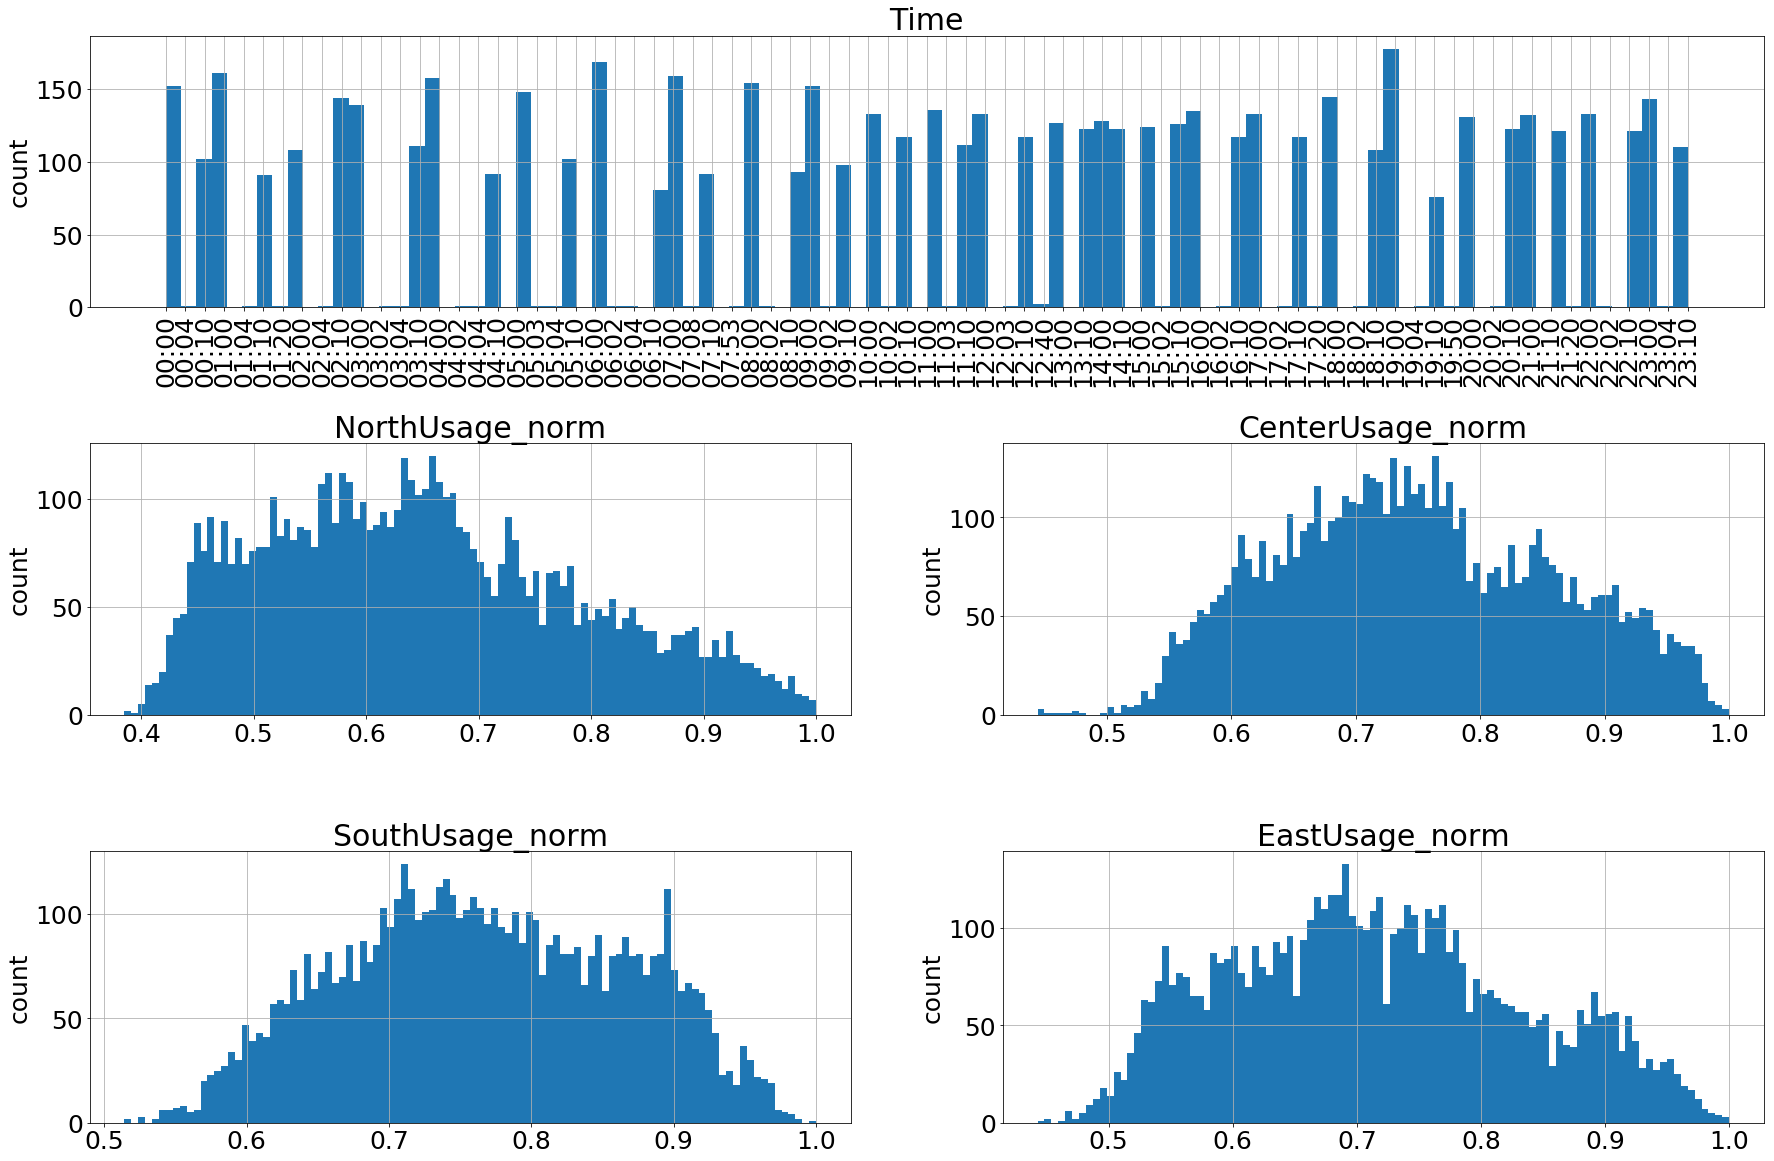

In [15]:
fig, ax = plt.subplots(figsize=(30, 20))
plt.rcParams.update({'font.size': 25})
fig.subplots_adjust(hspace=.5)

plt.subplot(3, 1, 1)
q1['Time'].hist(bins = 100)
plt.xticks(rotation='vertical')
plt.title('Time')
plt.ylabel('count')

plt.subplot(3, 2, 3)
q1['NorthUsage_norm'].hist(bins = 100)
plt.title('NorthUsage_norm')
plt.ylabel('count')

plt.subplot(3, 2, 4)
q1['CenterUsage_norm'].hist(bins = 100)
plt.title('CenterUsage_norm')
plt.ylabel('count')

plt.subplot(3, 2, 5)
q1['SouthUsage_norm'].hist(bins = 100)
plt.title('SouthUsage_norm')
plt.ylabel('count')

plt.subplot(3, 2, 6)
q1['EastUsage_norm'].hist(bins = 100)
plt.title('EastUsage_norm')
plt.ylabel('count')

#### From the figures above, we observe that
1. Based on normal worker's schedule, time can be discretized into three regions:
    - Work time: 08:00 to 18:00
    - Relax time: 18:00 to 24:00
    - Sleep time: 24:00 to 08:00
2. For electricity usage, all regions are close to normally distribution. Using K-means clustering for all of them should be a good strategy.

#### Time discretization

In [16]:
# Work time:
q1.loc[(q1['Time'] > '08:00') & (q1['Time'] <= '18:00'), 'Time_discre'] = 'Work'
# Relax time:
q1.loc[(q1['Time'] > '18:00') & (q1['Time'] <= '24:00'), 'Time_discre'] = 'Relax'
# Sleep time:
q1.loc[(q1['Time'] > '24:00') | (q1['Time'] <= '08:00'), 'Time_discre'] = 'Sleep'

In [17]:
# Check if there are NaN
q1['Time_discre'].unique()

array(['Work', 'Relax', 'Sleep'], dtype=object)

In [18]:
q1.head(24)

,Time,NorthUsage,CenterUsage,SouthUsage,EastUsage,NorthUsage_norm,CenterUsage_norm,SouthUsage_norm,EastUsage_norm,Time_discre
0,12:10,841.3,564.4,799.9,29.3,0.563987,0.595987,0.680245,0.559160,Work
1,13:10,826.4,535.9,777.9,27.6,0.553999,0.565892,0.661536,0.526718,Work
2,14:00,789.5,506.7,771.3,27.9,0.529262,0.535058,0.655923,0.532443,Work
3,15:10,773.6,450.8,737.3,29.5,0.518603,0.476030,0.627009,0.562977,Work
4,16:00,778.0,432.2,735.3,31.0,0.521553,0.456389,0.625308,0.591603,Work
5,17:00,783.1,449.1,739.4,34.1,0.524972,0.474234,0.628795,0.650763,Work
6,18:00,814.3,486.4,739.4,39.1,0.545887,0.513622,0.628795,0.746183,Work
7,19:00,812.4,478.0,725.2,39.6,0.544614,0.504752,0.616719,0.755725,Relax
8,20:00,809.0,490.5,717.4,41.1,0.542334,0.517951,0.610086,0.784351,Relax
9,21:00,796.6,487.1,699.2,41.1,0.534022,0.514361,0.594608,0.784351,Relax


#### K-means clustering:

In [19]:
N = q1[['NorthUsage_norm']]
C = q1[['CenterUsage_norm']]
S = q1[['SouthUsage_norm']]
E = q1[['EastUsage_norm']]
n_clusters = 3
n_kmeans = KMeans(n_clusters, random_state=0).fit(N)
c_kmeans = KMeans(n_clusters, random_state=0).fit(C)
s_kmeans = KMeans(n_clusters, random_state=0).fit(S)
e_kmeans = KMeans(n_clusters, random_state=0).fit(E)
q1['North_grp'] = n_kmeans.labels_
q1['Center_grp'] = c_kmeans.labels_
q1['South_grp'] = s_kmeans.labels_
q1['East_grp'] = e_kmeans.labels_

# Notify the upper/lower bounds of each cluster
n_max_list = list(q1.groupby('North_grp')['NorthUsage_norm'].max())
n_min_list = list(q1.groupby('North_grp')['NorthUsage_norm'].min())
c_max_list = list(q1.groupby('Center_grp')['CenterUsage_norm'].max())
c_min_list = list(q1.groupby('Center_grp')['CenterUsage_norm'].min())
s_max_list = list(q1.groupby('South_grp')['SouthUsage_norm'].max())
s_min_list = list(q1.groupby('South_grp')['SouthUsage_norm'].min())
e_max_list = list(q1.groupby('East_grp')['EastUsage_norm'].max())
e_min_list = list(q1.groupby('East_grp')['EastUsage_norm'].min())

# Modify clusters' value by specific upper/lower bounds
q1[['North_grp']] = ["[%.2f, %.2f]" % (n_min_list[i], n_max_list[i]) for i in q1['North_grp']]
q1[['Center_grp']] = ["[%.2f, %.2f]" % (c_min_list[i], c_max_list[i]) for i in q1['Center_grp']]
q1[['South_grp']] = ["[%.2f, %.2f]" % (s_min_list[i], s_max_list[i]) for i in q1['South_grp']]
q1[['East_grp']] = ["[%.2f, %.2f]" % (e_min_list[i], e_max_list[i]) for i in q1['East_grp']]

for i in range(0, n_clusters):
    print("North clusters: [%.2f, %.2f]" %(n_min_list[i], n_max_list[i]))
for i in range(0, n_clusters):
    print("Center clusters: [%.2f, %.2f]" %(c_min_list[i], c_max_list[i]))
for i in range(0, n_clusters):
    print("South clusters: [%.2f, %.2f]" %(s_min_list[i], s_max_list[i]))
for i in range(0, n_clusters):
    print("East clusters: [%.2f, %.2f]" %(e_min_list[i], e_max_list[i]))

North clusters: [0.59, 0.76]
North clusters: [0.39, 0.59]
North clusters: [0.76, 1.00]
Center clusters: [0.82, 1.00]
Center clusters: [0.44, 0.68]
Center clusters: [0.68, 0.82]
South clusters: [0.70, 0.82]
South clusters: [0.51, 0.70]
South clusters: [0.82, 1.00]
East clusters: [0.66, 0.80]
East clusters: [0.44, 0.65]
East clusters: [0.80, 1.00]


### Step 3: Association Rules by FP-Growth:

In [20]:
# Add prefix for clarification
Time_items = ['Time_' + x for x in q1['Time_discre']]
N_items = ['N_usage' + x for x in q1['North_grp']]
C_items = ['C_usage' + x for x in q1['Center_grp']]
S_items = ['S_usage' + x for x in q1['South_grp']]
E_items = ['E_usage' + x for x in q1['East_grp']]

dataset = []
dataset.append(Time_items)
dataset.append(N_items)
dataset.append(C_items)
dataset.append(S_items)
dataset.append(E_items)

# Transpose to generater the format of transactions
transactions = list(zip(*dataset))
transactions

[('Time_Work',
  'N_usage[0.39, 0.59]',
  'C_usage[0.44, 0.68]',
  'S_usage[0.51, 0.70]',
  'E_usage[0.44, 0.65]'),
 ('Time_Work',
  'N_usage[0.39, 0.59]',
  'C_usage[0.44, 0.68]',
  'S_usage[0.51, 0.70]',
  'E_usage[0.44, 0.65]'),
 ('Time_Work',
  'N_usage[0.39, 0.59]',
  'C_usage[0.44, 0.68]',
  'S_usage[0.51, 0.70]',
  'E_usage[0.44, 0.65]'),
 ('Time_Work',
  'N_usage[0.39, 0.59]',
  'C_usage[0.44, 0.68]',
  'S_usage[0.51, 0.70]',
  'E_usage[0.44, 0.65]'),
 ('Time_Work',
  'N_usage[0.39, 0.59]',
  'C_usage[0.44, 0.68]',
  'S_usage[0.51, 0.70]',
  'E_usage[0.44, 0.65]'),
 ('Time_Work',
  'N_usage[0.39, 0.59]',
  'C_usage[0.44, 0.68]',
  'S_usage[0.51, 0.70]',
  'E_usage[0.44, 0.65]'),
 ('Time_Work',
  'N_usage[0.39, 0.59]',
  'C_usage[0.44, 0.68]',
  'S_usage[0.51, 0.70]',
  'E_usage[0.66, 0.80]'),
 ('Time_Relax',
  'N_usage[0.39, 0.59]',
  'C_usage[0.44, 0.68]',
  'S_usage[0.51, 0.70]',
  'E_usage[0.66, 0.80]'),
 ('Time_Relax',
  'N_usage[0.39, 0.59]',
  'C_usage[0.44, 0.68]',
  'S_

#### FP-Growth:
Orange3-fpgrowth can only deal with numeric data, so a pair of encoder/decoder is required

In [21]:
# Orange3's input must be mumeric. String is not allowed.
from orangecontrib.associate import fpgrowth as fpg
start = time.time()

itemset = set().union(*transactions)
# decoder: numeric to string
decoder = {i: k for i, k in enumerate(itemset)}
# encoder: string to numeric
encoder = {k: i for i, k in enumerate(itemset)}

# Set min. support and min. confidence
# Fine-tuning minsup and minconf can get us more insight! Try different values of them.

minsup = 900/len(transactions)
minconf = 0.6

# minsup = 1200/len(transactions)
# minconf = 0.9

itemsets =  dict(fpg.frequent_itemsets([[encoder[i] for i in t] for t in transactions], minsup))
rules = list(fpg.association_rules(itemsets, minconf))

print("Fpgrowth took", time.time() - start, "seconds.")
# Print # of rules
print(len(rules), "Results")

# Print # of transactions
print(len(transactions), "Transactions")
# Print minsup
print("minsup is", minsup)

Fpgrowth took 0.07520604133605957 seconds.
260 Results
6060 Transactions
minsup is 0.1485148514851485


In [22]:
for rule in rules:
    a = [decoder[i] for i in rule[0]]
    b = [decoder[i] for i in rule[1]]
    s, c = rule[2], rule[3]
    print(a, ' -> ', b, c)
# c = confidence
# a -> b is the rule

['E_usage[0.44, 0.65]', 'Time_Sleep', 'N_usage[0.39, 0.59]', 'S_usage[0.51, 0.70]']  ->  ['C_usage[0.44, 0.68]'] 0.9372990353697749
['C_usage[0.44, 0.68]', 'E_usage[0.44, 0.65]', 'N_usage[0.39, 0.59]', 'S_usage[0.51, 0.70]']  ->  ['Time_Sleep'] 0.8989976869699307
['E_usage[0.44, 0.65]', 'N_usage[0.39, 0.59]', 'S_usage[0.51, 0.70]']  ->  ['C_usage[0.44, 0.68]', 'Time_Sleep'] 0.8406633020908435
['C_usage[0.44, 0.68]', 'Time_Sleep', 'N_usage[0.39, 0.59]', 'S_usage[0.51, 0.70]']  ->  ['E_usage[0.44, 0.65]'] 0.9676348547717842
['Time_Sleep', 'N_usage[0.39, 0.59]', 'S_usage[0.51, 0.70]']  ->  ['C_usage[0.44, 0.68]', 'E_usage[0.44, 0.65]'] 0.8880426504188881
['C_usage[0.44, 0.68]', 'N_usage[0.39, 0.59]', 'S_usage[0.51, 0.70]']  ->  ['E_usage[0.44, 0.65]', 'Time_Sleep'] 0.787305874409183
['N_usage[0.39, 0.59]', 'S_usage[0.51, 0.70]']  ->  ['C_usage[0.44, 0.68]', 'E_usage[0.44, 0.65]', 'Time_Sleep'] 0.7127139364303179
['C_usage[0.44, 0.68]', 'E_usage[0.44, 0.65]', 'Time_Sleep', 'S_usage[0.51, 0

In [23]:
# decoder

In [24]:
# encoder

### Step 4: Explanation and Conclusion
- Sleep time electricity usage:
    - Rules: 
        - ['C_usage[0.44, 0.68]', 'E_usage[0.44, 0.65]', 'N_usage[0.39, 0.59]']  ->  ['Time_Sleep'] 0.875
        - ['E_usage[0.44, 0.65]', 'S_usage[0.51, 0.70]', 'N_usage[0.39, 0.59]']  ->  ['Time_Sleep'] 0.8968997837058399
        - ['C_usage[0.44, 0.68]', 'S_usage[0.51, 0.70]', 'N_usage[0.39, 0.59]']  ->  ['Time_Sleep'] 0.8136394328156651
    - From the rules, we discover that during the sleep time, northern electricity usage is within the lowest range, and others, center, south, and east, are within the middle range of usage.
    - Interpretation: At the sleep time, people in the north use much less electricity at the sleep time compared to the work/relax time, while people in the center, south, and east keep moderate electricity usage during sleep time. Note that this does not mean people in the north use less electricity than other regions, since the numbers are normalized.
    - Setting: minsup = 1200/len(transactions), minconf = 0.8
- Maximum electricity usage analysis:
    - Rules:
        - ['S_usage[0.82, 1.00]', 'N_usage[0.76, 1.00]']  ->  ['C_usage[0.82, 1.00]'] 0.9741051028179741
        - ['C_usage[0.82, 1.00]', 'N_usage[0.76, 1.00]']  ->  ['S_usage[0.82, 1.00]'] 0.9704097116843703
        - ['C_usage[0.82, 1.00]', 'S_usage[0.82, 1.00]']  ->  ['N_usage[0.76, 1.00]'] 0.8023839397741531
    - Interpretation: For north, center, and south regions, whenever there are two of regions having relative high electricity usage, the other region will also have high electricity usage. It show a homogeneous electricity usage habit across Taiwan.
    - Setting: minsup = 1200/len(transactions), minconf = 0.8
- Work time electricity usage:
    - Rules:
        - ['C_usage[0.82, 1.00]', 'N_usage[0.76, 1.00]']  ->  ['Time_Work'] 0.6843702579666161
        - ['S_usage[0.82, 1.00]', 'N_usage[0.76, 1.00]']  ->  ['Time_Work'] 0.6877380045696877
    - Interpretation: High electricity usage of both center and north or south and north will imply that it is the work time.
    - Setting: minsup = 900/len(transactions), minconf = 0.6